# Family of Matrices
* Dense Matrix: $A_{i,j}$
* Linear Functions: $\alpha y_1 + \beta y_2 = f(\alpha x_1 + \beta x_2)$
* Sparse Matrix
    * CSC matrix
    * Diagonal
    * ...

# Time You Program

## Example 1: Swap Rows

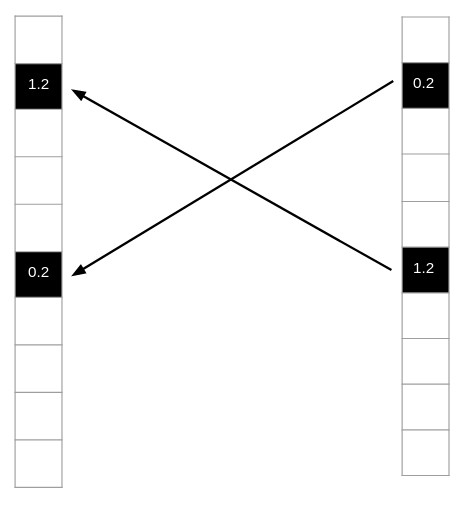

# Naive implementation

In [2]:
function swaprows!(v::VecOrMat, i::Int, j::Int)
    temp = v[i, :]
    v[i, :] = v[j, :]
    v[j, :] = temp
    v
end

swaprows! (generic function with 1 method)

# use **@time** to time your program

In [3]:
m = randn(1<<16, 8)

function test_swaprow(m::VecOrMat)
    N = size(m, 1)
    for i = 1:N-1
        swaprows!(m, i, i+1)
    end
    m
end

@time test_swaprow(m);
@time test_swaprow(m);

  0.120162 seconds (689.00 k allocations: 27.932 MiB, 5.44% gc time)
  0.022197 seconds (653.31 k allocations: 25.969 MiB, 17.47% gc time)


# use **@benchmark** for serious benchmarks

* Not warming up system

    * JITing code
    * Caches

* Unstable processor frequency

* Timing too short a run

In [4]:
using BenchmarkTools
@benchmark test_swaprow($m)

BenchmarkTools.Trial: 
  memory estimate:  25.97 MiB
  allocs estimate:  653308
  --------------
  minimum time:     12.866 ms (7.65% GC)
  median time:      17.959 ms (8.86% GC)
  mean time:        18.326 ms (10.94% GC)
  maximum time:     27.736 ms (12.75% GC)
  --------------
  samples:          273
  evals/sample:     1

In [4]:
@allocated swaprows!(m, 29, 165)

352

# Avoid Allocation

In [5]:
function swaprows!(v::VecOrMat{T}, i::Int, j::Int) where T
    for c = 1:size(v, 2)
        temp = v[i, c]
        v[i, c] = v[j, c]
        v[j, c] = temp
    end
    v
end
@benchmark test_swaprow($m)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.459 ms (0.00% GC)
  median time:      1.524 ms (0.00% GC)
  mean time:        1.582 ms (0.00% GC)
  maximum time:     2.926 ms (0.00% GC)
  --------------
  samples:          3147
  evals/sample:     1

# Even Faster

In [6]:
@inline function swaprows!(v::VecOrMat{T}, i::Int, j::Int) where T
    @inbounds @simd for c = 1:size(v, 2)
        temp = v[i, c]
        v[i, c] = v[j, c]
        v[j, c] = temp
    end
    v
end
@benchmark test_swaprow($m)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.141 ms (0.00% GC)
  median time:      1.196 ms (0.00% GC)
  mean time:        1.248 ms (0.00% GC)
  maximum time:     2.578 ms (0.00% GC)
  --------------
  samples:          3987
  evals/sample:     1

# LinearMaps.jl
A Julia package for defining and working with linear maps, also known as linear transformations or linear operators acting on vectors.

In [2]:
using LinearMaps
lo = LinearMap{Float64}(x->swaprows!(copy(x), 2, 7), 8)
v = randn(8)
println(lo * v)
E, V = eigs(lo, nev=6, which=:SR)
println(E)

[-0.467109, -0.0422354, -0.657699, 0.129567, 1.36689, -1.39999, -0.899679, -0.256501]
Complex{Float64}[-1.0+0.0im, 1.0+0.0im, 1.0+0.0im, 1.0+0.0im, 1.0+0.0im, 1.0+0.0im]


In [5]:
?eigs

Complex{Float64}[-1.0+0.0im, 1.0+0.0im, 1.0+0.0im, 1.0+0.0im, 1.0+0.0im, 1.0+0.0im]


```
eigs(A; nev=6, ncv=max(20,2*nev+1), which=:LM, tol=0.0, maxiter=300, sigma=nothing, ritzvec=true, v0=zeros((0,))) -> (d,[v,],nconv,niter,nmult,resid)
```

Computes eigenvalues `d` of `A` using implicitly restarted Lanczos or Arnoldi iterations for real symmetric or general nonsymmetric matrices respectively.

The following keyword arguments are supported:

  * `nev`: Number of eigenvalues
  * `ncv`: Number of Krylov vectors used in the computation; should satisfy `nev+1 <= ncv <= n` for real symmetric problems and `nev+2 <= ncv <= n` for other problems, where `n` is the size of the input matrix `A`. The default is `ncv = max(20,2*nev+1)`. Note that these restrictions limit the input matrix `A` to be of dimension at least 2.
  * `which`: type of eigenvalues to compute. See the note below.

| `which` | type of eigenvalues                                                                                                       |
|:------- |:------------------------------------------------------------------------------------------------------------------------- |
| `:LM`   | eigenvalues of largest magnitude (default)                                                                                |
| `:SM`   | eigenvalues of smallest magnitude                                                                                         |
| `:LR`   | eigenvalues of largest real part                                                                                          |
| `:SR`   | eigenvalues of smallest real part                                                                                         |
| `:LI`   | eigenvalues of largest imaginary part (nonsymmetric or complex `A` only)                                                  |
| `:SI`   | eigenvalues of smallest imaginary part (nonsymmetric or complex `A` only)                                                 |
| `:BE`   | compute half of the eigenvalues from each end of the spectrum, biased in favor of the high end. (real symmetric `A` only) |

  * `tol`: parameter defining the relative tolerance for convergence of Ritz values (eigenvalue estimates).    A Ritz value $θ$ is considered converged when its associated residual    is less than or equal to the product of `tol` and $max(ɛ^{2/3}, |θ|)$,    where `ɛ = eps(real(eltype(A)))/2` is LAPACK's machine epsilon.    The residual associated with $θ$ and its corresponding Ritz vector $v$    is defined as the norm $||Av - vθ||$.    The specified value of `tol` should be positive; otherwise, it is ignored    and $ɛ$ is used instead.    Default: $ɛ$.
  * `maxiter`: Maximum number of iterations (default = 300)
  * `sigma`: Specifies the level shift used in inverse iteration. If `nothing` (default), defaults to ordinary (forward) iterations. Otherwise, find eigenvalues close to `sigma` using shift and invert iterations.
  * `ritzvec`: Returns the Ritz vectors `v` (eigenvectors) if `true`
  * `v0`: starting vector from which to start the iterations

`eigs` returns the `nev` requested eigenvalues in `d`, the corresponding Ritz vectors `v` (only if `ritzvec=true`), the number of converged eigenvalues `nconv`, the number of iterations `niter` and the number of matrix vector multiplications `nmult`, as well as the final residual vector `resid`.

# Example

```jldoctest
julia> A = spdiagm(1:4);

julia> λ, ϕ = eigs(A, nev = 2);

julia> λ
2-element Array{Float64,1}:
 4.0
 3.0
```

!!! note
    The `sigma` and `which` keywords interact: the description of eigenvalues searched for by `which` do *not* necessarily refer to the eigenvalues of `A`, but rather the linear operator constructed by the specification of the iteration mode implied by `sigma`.

    | `sigma`         | iteration mode                   | `which` refers to eigenvalues of |
    |:--------------- |:-------------------------------- |:-------------------------------- |
    | `nothing`       | ordinary (forward)               | $A$                              |
    | real or complex | inverse with level shift `sigma` | $(A - \sigma I )^{-1}$           |


!!! note
    Although `tol` has a default value, the best choice depends strongly on the matrix `A`. We recommend that users _always_ specify a value for `tol` which suits their specific needs.

    For details of how the errors in the computed eigenvalues are estimated, see:

      * B. N. Parlett, "The Symmetric Eigenvalue Problem", SIAM: Philadelphia, 2/e (1998), Ch. 13.2, "Accessing Accuracy in Lanczos Problems", pp. 290-292 ff.
      * R. B. Lehoucq and D. C. Sorensen, "Deflation Techniques for an Implicitly Restarted Arnoldi Iteration", SIAM Journal on Matrix Analysis and Applications (1996), 17(4), 789–821.  doi:10.1137/S0895479895281484


```
eigs(A, B; nev=6, ncv=max(20,2*nev+1), which=:LM, tol=0.0, maxiter=300, sigma=nothing, ritzvec=true, v0=zeros((0,))) -> (d,[v,],nconv,niter,nmult,resid)
```

Computes generalized eigenvalues `d` of `A` and `B` using implicitly restarted Lanczos or Arnoldi iterations for real symmetric or general nonsymmetric matrices respectively.

The following keyword arguments are supported:

  * `nev`: Number of eigenvalues
  * `ncv`: Number of Krylov vectors used in the computation; should satisfy `nev+1 <= ncv <= n` for real symmetric problems and `nev+2 <= ncv <= n` for other problems, where `n` is the size of the input matrices `A` and `B`. The default is `ncv = max(20,2*nev+1)`. Note that these restrictions limit the input matrix `A` to be of dimension at least 2.
  * `which`: type of eigenvalues to compute. See the note below.

| `which` | type of eigenvalues                                                                                                       |
|:------- |:------------------------------------------------------------------------------------------------------------------------- |
| `:LM`   | eigenvalues of largest magnitude (default)                                                                                |
| `:SM`   | eigenvalues of smallest magnitude                                                                                         |
| `:LR`   | eigenvalues of largest real part                                                                                          |
| `:SR`   | eigenvalues of smallest real part                                                                                         |
| `:LI`   | eigenvalues of largest imaginary part (nonsymmetric or complex `A` only)                                                  |
| `:SI`   | eigenvalues of smallest imaginary part (nonsymmetric or complex `A` only)                                                 |
| `:BE`   | compute half of the eigenvalues from each end of the spectrum, biased in favor of the high end. (real symmetric `A` only) |

  * `tol`: relative tolerance used in the convergence criterion for eigenvalues, similar to    `tol` in the [`eigs(A)`](@ref) method for the ordinary eigenvalue    problem, but effectively for the eigenvalues of $B^{-1} A$ instead of $A$.    See the documentation for the ordinary eigenvalue problem in    [`eigs(A)`](@ref) and the accompanying note about `tol`.
  * `maxiter`: Maximum number of iterations (default = 300)
  * `sigma`: Specifies the level shift used in inverse iteration. If `nothing` (default), defaults to ordinary (forward) iterations. Otherwise, find eigenvalues close to `sigma` using shift and invert iterations.
  * `ritzvec`: Returns the Ritz vectors `v` (eigenvectors) if `true`
  * `v0`: starting vector from which to start the iterations

`eigs` returns the `nev` requested eigenvalues in `d`, the corresponding Ritz vectors `v` (only if `ritzvec=true`), the number of converged eigenvalues `nconv`, the number of iterations `niter` and the number of matrix vector multiplications `nmult`, as well as the final residual vector `resid`.

# Example

```jldoctest
julia> A = speye(4, 4); B = spdiagm(1:4);

julia> λ, ϕ = eigs(A, B, nev = 2);

julia> λ
2-element Array{Float64,1}:
 1.0
 0.5
```

!!! note
    The `sigma` and `which` keywords interact: the description of eigenvalues searched for by `which` do *not* necessarily refer to the eigenvalue problem $Av = Bv\lambda$, but rather the linear operator constructed by the specification of the iteration mode implied by `sigma`.

    | `sigma`         | iteration mode                   | `which` refers to the problem  |
    |:--------------- |:-------------------------------- |:------------------------------ |
    | `nothing`       | ordinary (forward)               | $Av = Bv\lambda$               |
    | real or complex | inverse with level shift `sigma` | $(A - \sigma B )^{-1}B = v\nu$ |



search: eigs eigvecs eigvals eigvals! leading_ones leading_zeros eig eigmin



# Time Evolution $e^{-iHt}$

$H$ is hermitian: $H'=H$

In [19]:
# Pkg.clone("https://github.com/GiggleLiu/Expokit.jl.git")
using Expokit
A = randn(8,8)
v = randn(8)
t = 0.1
expmv(-im*t, lo, v)

8-element Array{Complex{Float64},1}:
  -1.83923+0.184538im 
 -0.169705-0.105687im 
  -1.15099+0.115484im 
  0.115999-0.0116388im
  -1.03657+0.104003im 
  0.586516-0.0588478im
   1.05335+0.0170273im
  -2.36512+0.237304im 

In [13]:
?expmv

search: 

```
expmv{T}(t, A, vec; [tol], [m], [norm])
```

Calculate matrix exponential acting on some vector, $w = e^{tA}v$, using the Krylov subspace approximation.

See R.B. Sidje, ACM Trans. Math. Softw., 24(1):130-156, 1998 and http://www.maths.uq.edu.au/expokit


expmv expmv! expm1 expm



# ExpmV can be even faster
### Matrix density 0.001
| Matrix rows                   |  `Expm` | `Expokit` | `ExpmV`               |
|-----------------------|---------:|-----------:|-------:|
| 32      |  31.147 μs  | 12.144 μs  | 55.103 μs |
| 64      | 471.424 μs  | 15.816 μs  | 53.599 μs |
| 128     |   7.368 ms  | 34.339 μs  | 60.320 μs |
| 256     |  27.817 ms  | 61.137 μs  | 76.773 μs |
| 512     | 325.282 ms  |182.016 μs  |142.402 μs |
| 1024    |    1.568 s  |  2.137 ms  |306.293 μs |

But for now, it support only SparseMatrixCSC as input.

# On my laptop

In [20]:
sp = sprand(1024, 1024, 0.001)
v = randn(1024)

# scipy is ~2ms
@benchmark expmv(1, $sp, $v)

BenchmarkTools.Trial: 
  memory estimate:  570.77 KiB
  allocs estimate:  100
  --------------
  minimum time:     835.185 μs (0.00% GC)
  median time:      885.291 μs (0.00% GC)
  mean time:        1.731 ms (1.79% GC)
  maximum time:     50.582 ms (0.00% GC)
  --------------
  samples:          2883
  evals/sample:     1

# Example 2: 2×2 matrix apply on rows

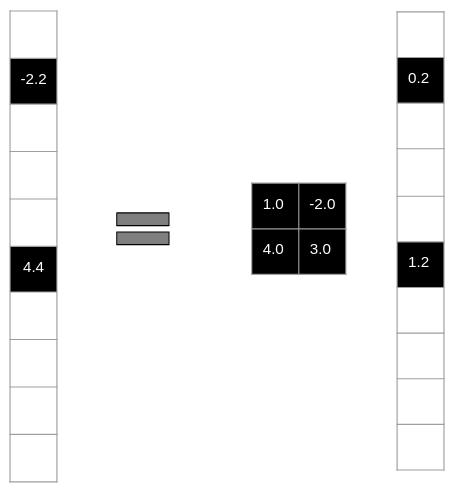

In [14]:
@inline function unrows!(state::Matrix, inds::AbstractVector, U::AbstractMatrix)
    @simd for k in 1:size(state, 2)
        @inbounds state[inds, k] .= U*view(state, inds, k)
    end
    state
end

unrows! (generic function with 1 method)

# Normally, we use 2 × 2 Matrix

In [16]:
u1 = randn(2,2)
inds1 =  [1,3]  # apply on position 1,3

state = randn(1000, 8)
@benchmark unrows!($state, $inds1, $u1)

BenchmarkTools.Trial: 
  memory estimate:  1.38 KiB
  allocs estimate:  24
  --------------
  minimum time:     452.401 ns (0.00% GC)
  median time:      566.939 ns (0.00% GC)
  mean time:        727.086 ns (23.87% GC)
  maximum time:     19.972 μs (93.65% GC)
  --------------
  samples:          10000
  evals/sample:     197

# StaticArrays


Statically sized arrays for Julia

StaticArrays.jl

https://github.com/JuliaArrays/StaticArrays.jl

In [30]:
using StaticArrays
v = SVector{3}([1, 2, 3])
m = SMatrix{2,2}([1 3 ; 2 4])

2×2 StaticArrays.SArray{Tuple{2,2},Int64,2,4}:
 1  3
 2  4

## Speed

The speed of small SVectors, SMatrixs and SArrays is often > 10 × faster than Base.Array. See this simplified benchmark (or see the full results here):

```
============================================
    Benchmarks for 3×3 Float64 matrices
============================================

Matrix multiplication               -> 8.2x speedup
Matrix multiplication (mutating)    -> 3.1x speedup
Matrix addition                     -> 45x speedup
Matrix addition (mutating)          -> 5.1x speedup
Matrix determinant                  -> 170x speedup
Matrix inverse                      -> 125x speedup
Matrix symmetric eigendecomposition -> 82x speedup
Matrix Cholesky decomposition       -> 23.6x speedup
```
These results improve significantly when using julia -O3 with immutable static arrays, as the extra optimization results in surprisingly good SIMD code.

# static arrays can avoid allocations

In [18]:
su1 = SMatrix{2,2}(u1)
@benchmark unrows!($state, $inds1, $su1)

INFO: Recompiling stale cache file /home/leo/.julia/lib/v0.6/StaticArrays.ji for module StaticArrays.


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     23.454 ns (0.00% GC)
  median time:      23.515 ns (0.00% GC)
  mean time:        23.636 ns (0.00% GC)
  maximum time:     98.341 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     996

# The expanded realization, even faster!

In [22]:
@inline function u1rows!(state::Matrix, i::Int,j::Int, a, b, c, d)
    @inbounds @simd for col = 1:size(state, 2)
        w = state[i, col]
        v = state[j, col]
        state[i, col] = a*w+b*v
        state[j, col] = c*w+d*v
    end
    state
end

i, j = inds1
a, b, c, d = u1
@benchmark u1rows!($state, $i, $j, $a, $b, $c, $d)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     13.594 ns (0.00% GC)
  median time:      13.629 ns (0.00% GC)
  mean time:        13.779 ns (0.00% GC)
  maximum time:     116.071 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     998

# So far
* How to `@time` and `@benchmark` a piece of code
* Use `@simd`, `@inbounds` and `@inline` to speed up codes
* Use `LinearMaps.jl` to view a linear function as a matrix
* Use `Expokit` to perform time evolution
* Use `StaticArrays.jl` for small matrices of fixed size to avoid allocation

What I am going to talk
* Sparse Matrices
* Tensor Operations

# Sparse matrices
There are seven available sparse matrix types in **scipy**:
* **csc_matrix**: Compressed Sparse Column format
* csr_matrix: Compressed Sparse Row format
* bsr_matrix: Block Sparse Row format
* lil_matrix: List of Lists format
* dok_matrix: Dictionary of Keys format
* coo_matrix: COOrdinate format (aka IJV, triplet format)
* **dia_matrix**: DIAgonal format

# Example 3: Sparse Matrix
$$\left(\begin{matrix}
1 & 0 & 2\\
4 & 0 & 0\\
0 & 3 & 0
\end{matrix}\right)$$

data structure of CSC matrix
* colptr = [1, 3, 4, 5],
* rowval = [1,2,3,1],
* nzval = [1,4,3,2].

In [5]:
sa1 = sparse([1,1,2,3], [1,3,1,2],[1,2,4,3])
sa1 |> Matrix

3×3 Array{Int64,2}:
 1  0  2
 4  0  0
 0  3  0

In [41]:
?sparse

```
sparse(A)
```

Convert an AbstractMatrix `A` into a sparse matrix.

```jldoctest
julia> A = eye(3)
3×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

julia> sparse(A)
3×3 SparseMatrixCSC{Float64,Int64} with 3 stored entries:
  [1, 1]  =  1.0
  [2, 2]  =  1.0
  [3, 3]  =  1.0
```

```
sparse(I, J, V,[ m, n, combine])
```

Create a sparse matrix `S` of dimensions `m x n` such that `S[I[k], J[k]] = V[k]`. The `combine` function is used to combine duplicates. If `m` and `n` are not specified, they are set to `maximum(I)` and `maximum(J)` respectively. If the `combine` function is not supplied, `combine` defaults to `+` unless the elements of `V` are Booleans in which case `combine` defaults to `|`. All elements of `I` must satisfy `1 <= I[k] <= m`, and all elements of `J` must satisfy `1 <= J[k] <= n`. Numerical zeros in (`I`, `J`, `V`) are retained as structural nonzeros; to drop numerical zeros, use [`dropzeros!`](@ref).

For additional documentation and an expert driver, see `Base.SparseArrays.sparse!`.

```jldoctest
julia> Is = [1; 2; 3];

julia> Js = [1; 2; 3];

julia> Vs = [1; 2; 3];

julia> sparse(Is, Js, Vs)
3×3 SparseMatrixCSC{Int64,Int64} with 3 stored entries:
  [1, 1]  =  1
  [2, 2]  =  2
  [3, 3]  =  3
```


search: sparse sparsevec SparseVector SparseArrays SparseMatrixCSC issparse



In [24]:
sa = SparseMatrixCSC(3, 3, [1,3,4,5], [1,2,3,1], [1,4,3,2])
sa |> Matrix

3×3 Array{Int64,2}:
 1  0  2
 4  0  0
 0  3  0

In [25]:
dump(sa)

SparseMatrixCSC{Int64,Int64}
  m: Int64 3
  n: Int64 3
  colptr: Array{Int64}((4,)) [1, 3, 4, 5]
  rowval: Array{Int64}((4,)) [1, 2, 3, 1]
  nzval: Array{Int64}((4,)) [1, 4, 3, 2]


# Generalized Permutation Matrix

## Example: Control-Y Gate
$$\left(\begin{matrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & -i\\
0 & 0 & i & 0\\
\end{matrix}\right)$$

data structure of `PermMatrix`
* perm: [1, 2, 4, 3]
* vals: [1, 1, -i, i]

In [6]:
using Yao.LuxurySparse
pm = PermMatrix([1,2,4,3], [1,1,-im,im])

4×4 Yao.LuxurySparse.PermMatrix{Complex{Int64},Int64,Array{Complex{Int64},1},Array{Int64,1}}:
 1+0im   0      0      0   
  0     1+0im   0      0   
  0      0      0     0-1im
  0      0     0+1im   0   

In [15]:
v = randn(4)
@benchmark $pm*$v

BenchmarkTools.Trial: 
  memory estimate:  144 bytes
  allocs estimate:  1
  --------------
  minimum time:     36.789 ns (0.00% GC)
  median time:      38.816 ns (0.00% GC)
  mean time:        49.227 ns (10.20% GC)
  maximum time:     1.629 μs (89.36% GC)
  --------------
  samples:          10000
  evals/sample:     992

In [16]:
sp = SparseMatrixCSC(pm)
@benchmark $sp*$v

BenchmarkTools.Trial: 
  memory estimate:  144 bytes
  allocs estimate:  1
  --------------
  minimum time:     64.578 ns (0.00% GC)
  median time:      65.769 ns (0.00% GC)
  mean time:        74.292 ns (6.80% GC)
  maximum time:     1.419 μs (87.15% GC)
  --------------
  samples:          10000
  evals/sample:     979

# Identity Matrix
### Type Parameters v.s. Members
Suppose we want to realize an identity matrix, we have two choices
* let size $N$ be a **type parameter**
* let size $n$ be a **member**

In [18]:
# static size
struct IMatrixS{N, Tv} <: AbstractMatrix{Tv} end

# dynamic size
struct IMatrixD{Tv} <: AbstractMatrix{Tv}
    n::Int
end

# Kronecher Product

$$\left(
\begin{array}{cc}
 a_{11} & a_{12} \\
 a_{21} & a_{22} \\
\end{array}
\right)\otimes\left(
\begin{array}{cc}
 b_{11} & b_{12} \\
 b_{21} & b_{22} \\
 b_{31} & b_{32} \\
\end{array}
\right)=\left(
\begin{array}{cc}
 \left(
\begin{array}{cc}
 a_{11} b_{11} & a_{11} b_{12} \\
 a_{11} b_{21} & a_{11} b_{22} \\
 a_{11} b_{31} & a_{11} b_{32} \\
\end{array}
\right) & \left(
\begin{array}{cc}
 a_{12} b_{11} & a_{12} b_{12} \\
 a_{12} b_{21} & a_{12} b_{22} \\
 a_{12} b_{31} & a_{12} b_{32} \\
\end{array}
\right) \\
 \left(
\begin{array}{cc}
 a_{21} b_{11} & a_{21} b_{12} \\
 a_{21} b_{21} & a_{21} b_{22} \\
 a_{21} b_{31} & a_{21} b_{32} \\
\end{array}
\right) & \left(
\begin{array}{cc}
 a_{22} b_{11} & a_{22} b_{12} \\
 a_{22} b_{21} & a_{22} b_{22} \\
 a_{22} b_{31} & a_{22} b_{32} \\
\end{array}
\right) \\
\end{array}
\right)$$

If A is an m × n matrix and B is a p × q matrix, then the Kronecker product A ⊗ B is the mp × nq block matrix:
$$\mathbf{A}\otimes\mathbf{B} = \begin{bmatrix} a_{11} \mathbf{B} & \cdots & a_{1n}\mathbf{B} \\ \vdots & \ddots & \vdots \\ a_{m1} \mathbf{B} & \cdots & a_{mn} \mathbf{B} \end{bmatrix}$$, 
more explicitly:
$${\mathbf{A}\otimes\mathbf{B}} = \begin{bmatrix}
   a_{11} b_{11} & a_{11} b_{12} & \cdots & a_{11} b_{1q} &
                   \cdots & \cdots & a_{1n} b_{11} & a_{1n} b_{12} & \cdots & a_{1n} b_{1q} \\
   a_{11} b_{21} & a_{11} b_{22} & \cdots & a_{11} b_{2q} &
                   \cdots & \cdots & a_{1n} b_{21} & a_{1n} b_{22} & \cdots & a_{1n} b_{2q} \\
   \vdots & \vdots & \ddots & \vdots & & & \vdots & \vdots & \ddots & \vdots \\
   a_{11} b_{p1} & a_{11} b_{p2} & \cdots & a_{11} b_{pq} &
                   \cdots & \cdots & a_{1n} b_{p1} & a_{1n} b_{p2} & \cdots & a_{1n} b_{pq} \\
   \vdots & \vdots & & \vdots & \ddots & & \vdots & \vdots & & \vdots \\
   \vdots & \vdots & & \vdots & & \ddots & \vdots & \vdots & & \vdots \\
   a_{m1} b_{11} & a_{m1} b_{12} & \cdots & a_{m1} b_{1q} &
                   \cdots & \cdots & a_{mn} b_{11} & a_{mn} b_{12} & \cdots & a_{mn} b_{1q} \\
   a_{m1} b_{21} & a_{m1} b_{22} & \cdots & a_{m1} b_{2q} &
                   \cdots & \cdots & a_{mn} b_{21} & a_{mn} b_{22} & \cdots & a_{mn} b_{2q} \\
   \vdots & \vdots & \ddots & \vdots & & & \vdots & \vdots & \ddots & \vdots \\
   a_{m1} b_{p1} & a_{m1} b_{p2} & \cdots & a_{m1} b_{pq} &
                   \cdots & \cdots & a_{mn} b_{p1} & a_{mn} b_{p2} & \cdots & a_{mn} b_{pq}
\end{bmatrix}. $$
More compactly, we have 
$$ (A\otimes B)_{p(r-1)+v, q(s-1)+w} = a_{rs} b_{vw}$$


# Kronecker product for identity matrix
* if size is 1, do nothing
* else, do kronecker product

In [19]:
kron(A::IMatrixS{1}, B::AbstractMatrix) = B
kron(A::IMatrixS{N}, B::AbstractMatrix) where N = println("kron!")

kron(A::IMatrixD, B::AbstractMatrix) = A.n == 1 ? B : println("kron!") # potential type instability

kron (generic function with 3 methods)

In [20]:
Is = IMatrixS{1, Float64}()
Id = IMatrixD{Float64}(1)
B = randn(7,7);

In [21]:
@benchmark kron($Is, $B)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.642 ns (0.00% GC)
  median time:      1.651 ns (0.00% GC)
  mean time:        1.658 ns (0.00% GC)
  maximum time:     32.101 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000

In [22]:
@benchmark kron($Id, $B)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.031 ns (0.00% GC)
  median time:      6.049 ns (0.00% GC)
  mean time:        6.064 ns (0.00% GC)
  maximum time:     36.627 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000

# Additional Content: Tensor Operations
Fast tensor operations using a convenient index notation.
## Example
Einsten sum $y_i^j = x_{a}^b A_b^{p,j} A_{p,i}^{a~*}$
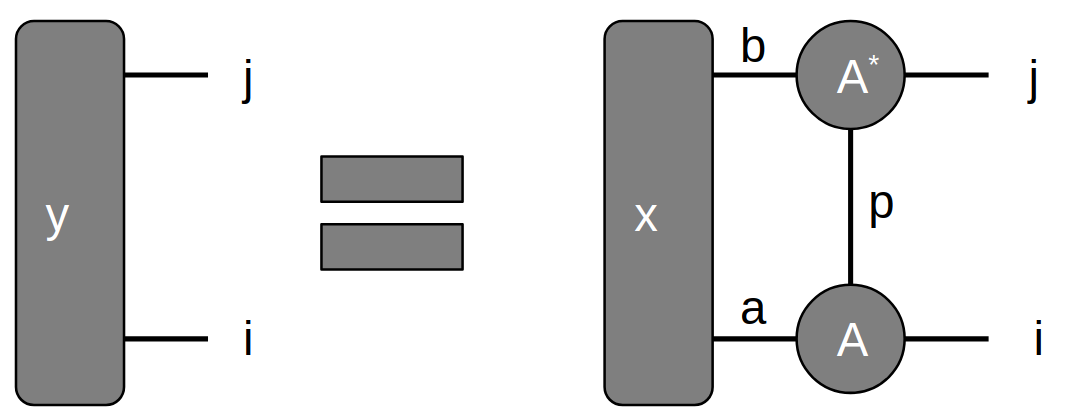

In [29]:
using TensorOperations
x = randn(20, 20)
A = randn(20, 2, 20)
@tensor y[i, j] := (x[a, b] * A[b, p, j]) * conj(A[a, p, i])

20×20 Array{Float64,2}:
  -0.177617   18.4366   -20.4183    …  -17.4491    94.0999    -58.8981  
  46.1862     36.3921   -19.422        -11.2613    -5.1424     17.195   
   8.36135    18.2125     8.45348      -16.1985   -18.1829     64.131   
   4.30528    35.1844     3.84166       10.7331    33.6842     34.3711  
 -17.9034      5.39187    0.699516      -5.22375   21.8379     29.5238  
   9.81681    -7.16406    5.40658   …  -19.5748    27.9285     38.1745  
  -6.75604    23.6781    28.442          3.44052  -43.5157    -32.9992  
   1.10377    48.2976   -25.9535       -20.4091    44.3723    -31.5959  
  48.9961     31.0177    -3.82585       12.5639    53.6334     66.5921  
 -10.8983    -15.5956   -23.3466         9.74706   50.9358     48.8262  
  57.5245    -38.6412     4.91289   …   -8.28242   21.4517      5.85023 
  -6.98091   -18.804     16.3603        -3.10294  -35.3248     -2.05165 
   1.04492    12.8999    41.731        -13.212     43.4116     18.0755  
 -11.1369    -38.1108    23

# Additional Content: Type stability
* **stable**: variable can be inferenced and has concrete type
* **instable**: not pointed to some allocated memory address, boxing is needed

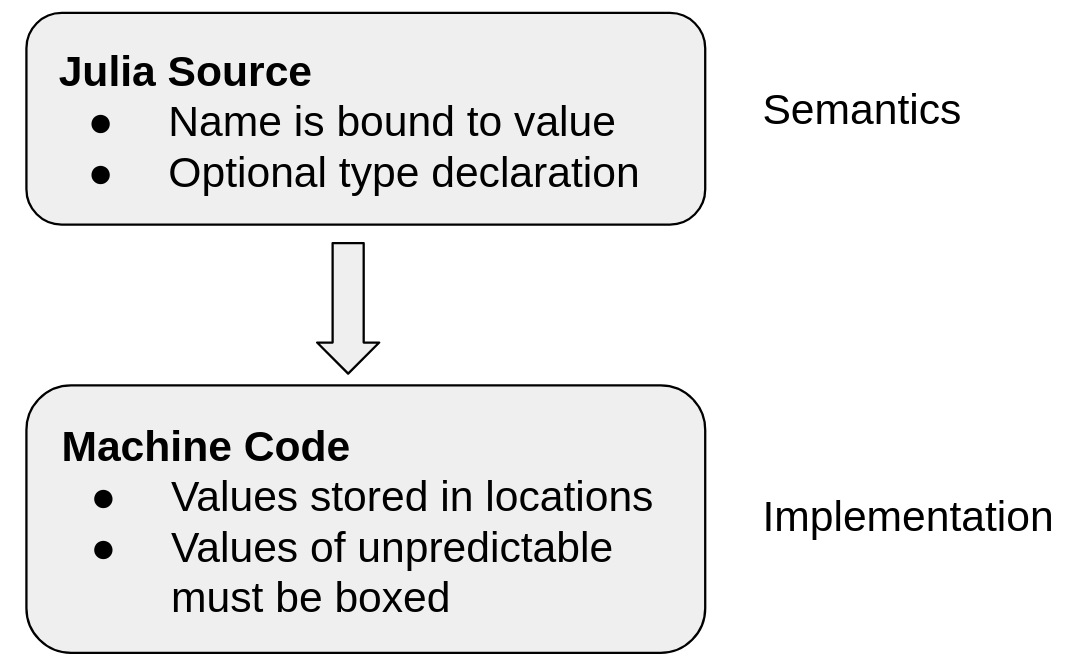

In [34]:
function f()
    x = 1.0
    x *= im
end

f (generic function with 1 method)

In [35]:
@code_warntype f()

Variables:
  #self#::#f
  x::Union{Complex{Float64}, Float64}

Body:
  begin 
      x::Union{Complex{Float64}, Float64} = 1.0 # line 3:
      SSAValue(0) = $(Expr(:new, Complex{Float64}, :((Base.select_value)((Core.getfield)(Main.im, :re)::Bool, x::Float64, (Base.copysign_float)((Base.sitofp)(Float64, 0)::Float64, x::Float64)::Float64)::Float64), :((Base.select_value)((Core.getfield)(Main.im, :im)::Bool, x::Float64, (Base.copysign_float)((Base.sitofp)(Float64, 0)::Float64, x::Float64)::Float64)::Float64)))
      x::Union{Complex{Float64}, Float64} = SSAValue(0)
      return SSAValue(0)
  end::Complex{Float64}


In [36]:
function f_iter()
    x = 1.0
    for i = 1:1000
        x *= im
    end
    x
end
@benchmark f_iter()

BenchmarkTools.Trial: 
  memory estimate:  62.48 KiB
  allocs estimate:  2000
  --------------
  minimum time:     21.540 μs (0.00% GC)
  median time:      22.625 μs (0.00% GC)
  mean time:        28.455 μs (16.60% GC)
  maximum time:     2.157 ms (95.53% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [48]:
function f_iter_stable()
    x = 1.0 + 0im
    for i = 1:1000
        x *= im
    end
    x
end
@benchmark f_iter_stable()

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.007 μs (0.00% GC)
  median time:      4.008 μs (0.00% GC)
  mean time:        4.014 μs (0.00% GC)
  maximum time:     7.862 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [50]:
@code_warntype f_iter_stable()

Variables:
  #self#::#f_iter_stable
  i::Int64
  #temp#::Int64
  x::Complex{Float64}

Body:
  begin 
      SSAValue(7) = (Base.select_value)((Core.getfield)(Main.im, :re)::Bool, 0, (Base.flipsign_int)(0, (Base.xor_int)(0, 0)::Int64)::Int64)::Int64
      SSAValue(8) = (Base.select_value)((Core.getfield)(Main.im, :im)::Bool, 0, (Base.flipsign_int)(0, (Base.xor_int)(0, 0)::Int64)::Int64)::Int64
      x::Complex{Float64} = $(Expr(:new, Complex{Float64}, :((Base.add_float)(1.0, (Base.sitofp)(Float64, SSAValue(7))::Float64)::Float64), :((Base.sitofp)(Float64, SSAValue(8))::Float64))) # line 3:
      SSAValue(9) = (Base.select_value)((Base.sle_int)(1, 1000)::Bool, 1000, (Base.sub_int)(1, 1)::Int64)::Int64
      #temp#::Int64 = 1
      7: 
      unless (Base.not_int)((#temp#::Int64 === (Base.add_int)(SSAValue(9), 1)::Int64)::Bool)::Bool goto 24
      SSAValue(10) = #temp#::Int64
      SSAValue(11) = (Base.add_int)(#temp#::Int64, 1)::Int64
      #temp#::Int64 = SSAValue(11) # line 4:
      $(Ex

### "const" Keyword and type check
Using `const` keyword/type check, one can partly avoid type instability. `const` in julia means **an identifier never rebound**.

These tricks are useful for especially global variables, but loss generality.

In [23]:
const c = 1

1

In [24]:
c = 3

3

In [26]:
c = 3.3

LoadError: [91minvalid redefinition of constant c[39m

In [27]:
# with type check
function f_iter_checktype()
    x::Float64 = 1.0
    for i = 1:1000
        x *= im
    end
    x
end
f_iter_checktype()

LoadError: [91mInexactError()[39m

# Thanks!
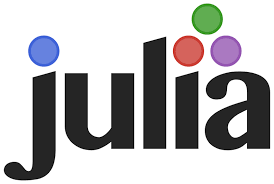

# end

In [1]:
在场的各位 = ["集智的工作者们", "软件所的老师和同学", "其他Julia爱好者们"]

3-element Array{String,1}:
 "集智的工作者们"    
 "软件所的老师和同学"  
 "其他Julia爱好者们"

In [38]:
for 你 in 在场的各位
    println("谢谢 $你 来捧场！")
end

谢谢 集智的工作者们 来捧场！
谢谢 软件所的老师和同学 来捧场！
谢谢 其他Julia爱好者们 来捧场！
